## Create Dendrogram for Correlations between Data Representation

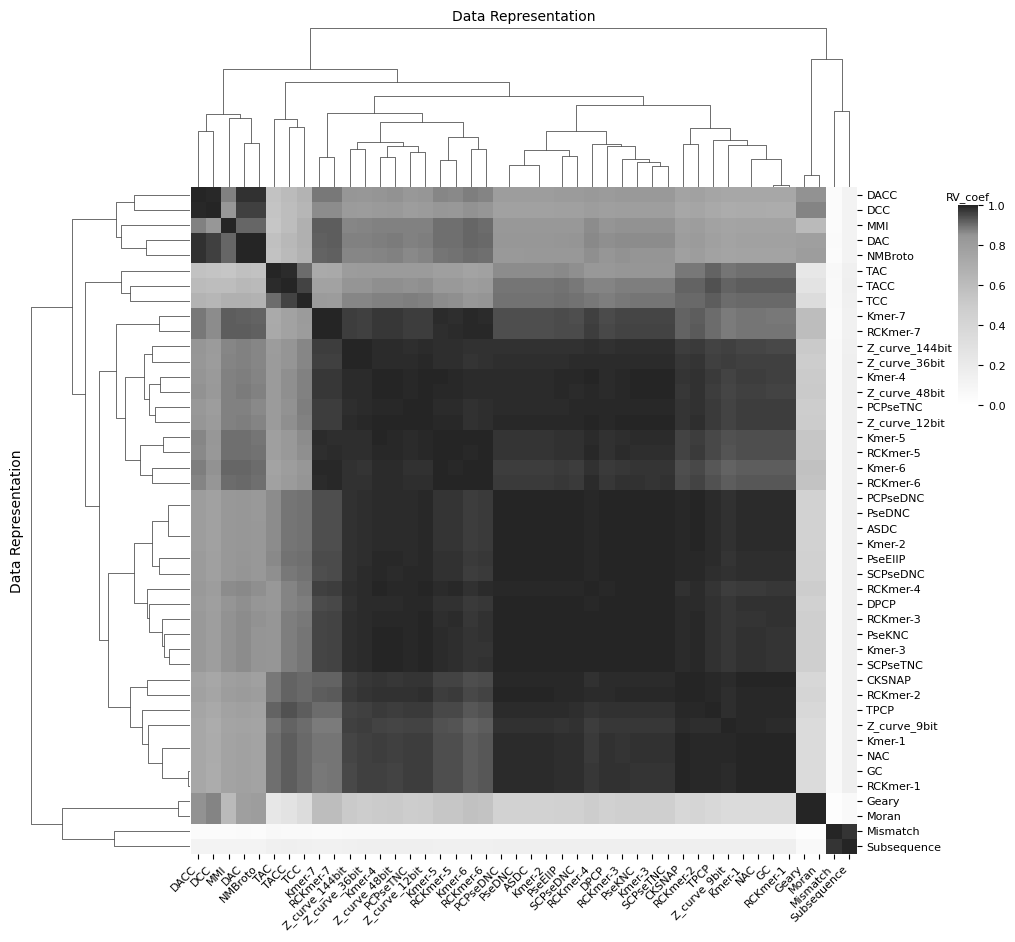

In [1]:
import pandas as pd 
import seaborn as sns 
import pickle 
import altair as alt  
from scipy.stats import ttest_ind
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

dataset = 'benbow'

# Step 1: read the results
adjusted_rv_r = pd.read_csv('../outputs/dataset_correlation/results_{}.tsv'.format(dataset), sep='\t', header=0) 
# Create the reversed DataFrame
adjusted_rv_r_reversed = adjusted_rv_r.rename(columns={'Encoding1': 'Encoding2', 'Encoding2': 'Encoding1'})

# Append the reversed DataFrame
rv_df_final = pd.concat([adjusted_rv_r, adjusted_rv_r_reversed], ignore_index=True)
df_final_pivot = rv_df_final.pivot(index='Encoding1', columns='Encoding2', values='Adjusted_RV')
rv_data = df_final_pivot.fillna(1.0)

data = rv_data 

# Step 2: Compute row and column linkage using hierarchical clustering
row_linkage = linkage(data.values, method='ward')
col_linkage = linkage(data.T.values, method='ward')

# Apply transformation to adjust branch heights
alpha = 0.25  # 0 < alpha < 1 stretches small values, compresses large ones
col_linkage[:, 2] = col_linkage[:, 2] ** alpha  # Adjust heights

# Step 3: Reorder the rows and columns based on the dendrogram
dendro_row = dendrogram(row_linkage, no_plot=True)
dendro_col = dendrogram(col_linkage, no_plot=True)

# Reorder the data based on the clustering
data_ordered = data.iloc[dendro_row['leaves'], :].iloc[:, dendro_col['leaves']]

# Define a Custom Grayscale Colormap (from dark gray to white)
custom_cmap = LinearSegmentedColormap.from_list("custom_gray", ["#f7f7f7", "#cccccc", "#969696", "#636363"])
# Define a nonlinear colormap
colors = [(0, "white"), (0.5,"#cccccc"), (0.85, "#969696"), (1,"#252525")]  # Define color transitions
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

g = sns.clustermap(rv_data, row_linkage=col_linkage, col_linkage=col_linkage, xticklabels=True, yticklabels=True,
               cbar_pos=(0.95, 0.6, 0.02, 0.2),
               cmap=custom_cmap,
               vmin=0, vmax=1)

# Set legend (color bar) title and font size
colorbar = g.ax_cbar  # Get colorbar axis
colorbar.set_xlabel("RV_coef", fontsize=8)  # Set title and font size
colorbar.yaxis.label.set_fontsize(8)  # Ensure title font size is applied
colorbar.tick_params(labelsize=8)  # Adjust tick font size
colorbar.xaxis.set_label_position("top")

# Rotate x-axis labels
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha="right", fontsize=8)  
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8)  

# Set x-axis title on top
g.ax_heatmap.set_xlabel("Data Representation", fontsize=10, labelpad=120)
g.ax_heatmap.xaxis.set_label_position("top")

# Set y-axis title on the left
g.ax_heatmap.set_ylabel("Data Representation", fontsize=10, labelpad=120)
g.ax_heatmap.yaxis.set_label_position("left")

plt.show()

In [2]:
#representation_dimensionality = pd.read_excel('../dataset/representation_dimensionality.xlsx')

# Read the feature groups
feature_groups = {
    'nac': ['Subsequence','Mismatch',
            'Kmer-1','Kmer-2','Kmer-3','Kmer-4','Kmer-5', 'Kmer-6', 'Kmer-7',
            'RCKmer-1','RCKmer-2','RCKmer-3','RCKmer-4','RCKmer-5','RCKmer-6','RCKmer-7',
            'NAC','GC','CKSNAP','ASDC',
            'Z_curve_9bit', 'Z_curve_12bit','Z_curve_36bit','Z_curve_48bit','Z_curve_144bit'],
    'pseudo_nac': ['PseDNC','PseKNC','PCPseDNC','PCPseTNC','SCPseDNC','SCPseTNC'],
    'eiip': ['PseEIIP'],
    'mi': ['MMI'],
    'utocorrelation and cross-covariance': ['DAC','DCC','DACC','TAC','TCC','TACC','Moran','Geary','NMBroto'],
    'physicochemical property': ['DPCP','TPCP'],
}

# Create a mapping for the feature groups
value_to_key = {v: k for k, values in feature_groups.items() for v in values}
rv_df_final['feature_group_1'] = rv_df_final['Encoding1'].map(value_to_key)
rv_df_final['feature_group_2'] = rv_df_final['Encoding2'].map(value_to_key)
rv_df_final['group'] = rv_df_final.apply(lambda x: 'intra-group' if x['feature_group_1'] == x['feature_group_2'] else 'inter-group', axis=1)

alt.Chart(rv_df_final).mark_boxplot(
    color='gray'
).encode(
    x=alt.X('group:O', title='Group', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Adjusted_RV:Q', scale=alt.Scale(domain=[0, 1]))
).properties(
    width=203,
)

alt.Chart(...)

In [3]:
# Perform t-test
intra = rv_df_final[rv_df_final['feature_group_1'] == rv_df_final['feature_group_2']]['Adjusted_RV']
inter = rv_df_final[rv_df_final['feature_group_1'] != rv_df_final['feature_group_2']]['Adjusted_RV']

stat, p = ttest_ind(intra, inter, equal_var=False)
print(f"T-test p-value: {p}")
print(f"Mean Intra-group Correlation: {intra.mean()}")
print(f"Mean Inter-group Correlation: {inter.mean()}")

T-test p-value: 0.03979894360051138
Mean Intra-group Correlation: 0.8341625560891148
Mean Inter-group Correlation: 0.8063893600811234


In [4]:
intra_inter_df = rv_df_final.groupby(['group','feature_group_1','feature_group_2']).mean()['Adjusted_RV'].sort_values(ascending=False).reset_index()
intra_inter_df.sort_values(by=['feature_group_1', 'Adjusted_RV'], ascending=[False, False])

/var/folders/ws/qg8ztb9n7yj1s15m1x9c1vdw0000gp/T/ipykernel_51767/3730154617.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  intra_inter_df = rv_df_final.groupby(['group','feature_group_1','feature_group_2']).mean()['Adjusted_RV'].sort_values(ascending=False).reset_index()


,group,feature_group_1,feature_group_2,Adjusted_RV
24,inter-group,utocorrelation and cross-covariance,pseudo_nac,0.761465
25,inter-group,utocorrelation and cross-covariance,eiip,0.760342
28,inter-group,utocorrelation and cross-covariance,physicochemical property,0.744289
30,inter-group,utocorrelation and cross-covariance,mi,0.734286
31,intra-group,utocorrelation and cross-covariance,utocorrelation and cross-covariance,0.707220
33,inter-group,utocorrelation and cross-covariance,nac,0.704520
1,inter-group,pseudo_nac,eiip,0.997673
2,intra-group,pseudo_nac,pseudo_nac,0.997090
6,inter-group,pseudo_nac,physicochemical property,0.989966
11,inter-group,pseudo_nac,nac,0.914920
